<a href="https://colab.research.google.com/github/bacdam91/Swinburne-Summer-Scholarship-Project/blob/master/SSSP_Recommender_System_with_GNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Assumptions
1. Due to a lack of data on developers' opinions (or rating scores) on libraries, we assume that the developers are satisfied with the library. 

# Preprocessing

### Mounting Google Drive
This code helps to mount Google Drive via an authorization code.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### URL for dataset
This url is for the edgelist of the dataset.

In [0]:
url = "/content/drive/My Drive/Colab Notebooks/GCN for TPL Recommendation/10-10-relation.csv"

### Importing ```pandas```

Importing ```pandas``` library for data manipulation.

In [0]:
import pandas as pd

### Defining constants
Defining some "constants":
1. Headers for dataframe columns

In [0]:
app_header = "AppID"
lib_header = "LibID"
headers = [app_header, lib_header]

### Read ```.csv``` as ```pd.DataFrame```
Read in the edgelist ```.csv``` file as a ```pd.DataFrame``` and ```display``` first 10 edges.

In [5]:
df = pd.read_csv(url, header=None, names=headers)
df[0:10]

,AppID,LibID
0,1,61
1,1,79
2,1,82
3,1,83
4,1,103
5,1,106
6,1,107
7,1,240
8,1,242
9,1,244


### Mini-Samples
Since there is __not__ enough computing power via Google Colab, we will work with a mini-batch of the first 100 apps, $u$, and associated libraries, $v$.

The sets of apps and libraries are represented as $U$ and $V$ respectively, where $M$ and $N$ represent the size of $U$ and $V$, respectively. The formal definition is as followed:
1. $U = \{u_{1}, u_{2} ,... u_{M}\}$
2. $V = \{v_{1}, v_{2} ,... v_{N}\}$
3. $M = |U|$
4. $N = |V|$

In [33]:
mini_sample_size = 5000
df_mini = df.loc[df[app_header] <= mini_sample_size]
print("Number of apps:", len(df_mini[app_header].unique()))
print("Number of libs:", len(df_mini[lib_header].unique()))
print("Edges:", df_mini.shape[0])

Number of apps: 5000
Number of libs: 701
Edges: 94701


From the output above, there are __94,701__ edges between the __5000__ apps and __701__ libraries. 


### Re-ID nodes
Before we can feed it into ```networkx``` to generate a graph $G$, we need to re-ID the entities, $e \in E$, i.e., the apps and the libraries, otherwise ```networkx``` would __not__ be able to differentiate between an app and a library since currently, both types of entities are numerically ID'ed.

The number of entities in graph $G$ equals to $M + N$. The formal definition is therefore:
1. $E = U \cup V = \{e_{1}, e_{2}, ...e_{M+N}\}$
2. $|E| = M + N = O$

We will also need to rename the columns with the previous column headers and display the new ```pd.DataFrame``` for inspection.

In [34]:
df_mini = df_mini.apply(lambda row : ["A" + str(row[app_header]), "L" + str(row[lib_header])], axis=1, result_type="expand")
df_mini = df_mini.rename(columns={0: app_header, 1: lib_header})
display(df_mini[0:10])

,AppID,LibID
0,A1,L61
1,A1,L79
2,A1,L82
3,A1,L83
4,A1,L103
5,A1,L106
6,A1,L107
7,A1,L240
8,A1,L242
9,A1,L244


### Importing ```numpy```
We will require ```numpy``` library for creating an array of edges. An edge represents a relation, $r_{uv} \in R$, between an app, $u_{i}$ and a library, $v_{j}$.

In [0]:
import numpy as np

### Creating node and edge lists

We will now extract the unique IDs of the apps and libraries to create arrays of app nodes and libraries nodes. We will then concatenate the two arrays to form the node list. The edge list can be created by converting the ```df_mini``` into an ```numpy.array```.

Therefore ```nodelist``` =  $E$ and ```edgelist``` = $R$.

In [0]:
app_nodes = pd.Series(df_mini[app_header].unique())
lib_nodes = pd.Series(df_mini[lib_header].unique())

nodelist = pd.concat([app_nodes, lib_nodes])
edgelist = np.array(df_mini)

### Visualising the data
We will set up some visualisation to inspect the dataset via ```networkx```.

### Importing ```networkx```
The library ```networkx``` allows us to quickly visualise graph data as well as manipulate graph attributes with ease. So let's import it.

We will import ```matplotlib.pyplot``` also so we can control the figure size.

In [0]:
import networkx as nx
import matplotlib.pyplot as plt

### Visualisation parameters

Let's define some parameters for our visualisation.

In [0]:
color_apps = "#3b91ed"
color_libs = "#ffac5e"
color_edge = "#9c9c9c"

alpha_node = 0.5
alpha_edge = 0.005

size_node = 50

### Creating a ```networkx.Graph```
Creating a ```networkx.Graph``` is as easy as calling the constructor method and adding in the edges with the method ```.add_edges_from()```.

In [0]:
G = nx.Graph()
G.add_edges_from(edgelist)

### Drawing the graph
Let's draw the graph with some of the parameters we defined above for visualisation purposes.

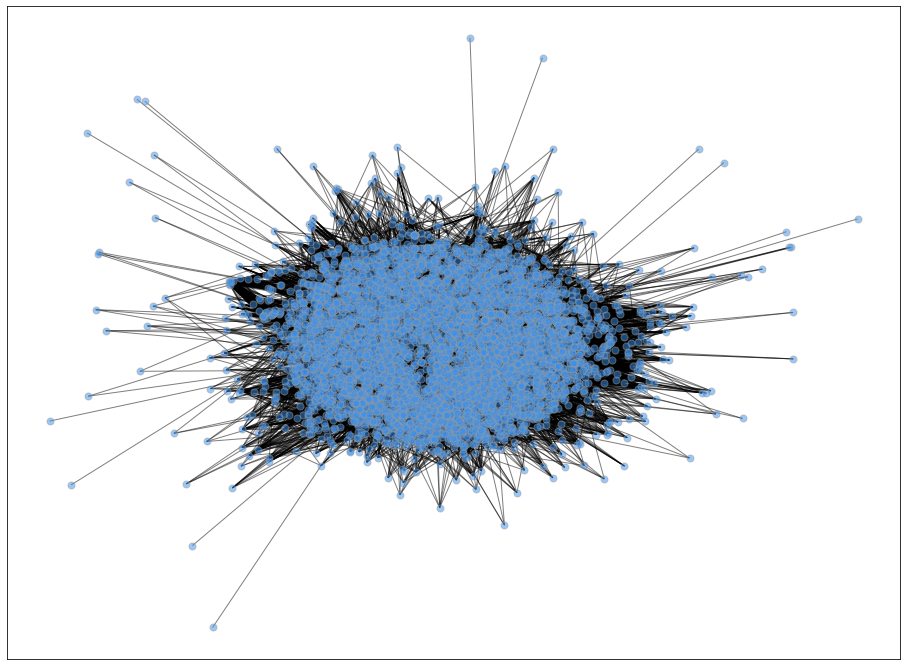

In [56]:
plt.figure(figsize=(16,12))
nx.draw_networkx(G, with_labels=False, node_size=size_node, node_color=color_apps, alpha=alpha_node, edgecolors=color_edge)

In [41]:
import mxnet.ndarray as nd

A = nx.to_numpy_matrix(G)
A = nd.array(A)
I = nd.eye(*A.shape)
A_hat = A.copy() + I
D = nd.sum(A_hat, axis=0)
D_inv = D**-0.5
D_inv = nd.diag(D_inv)
D_inv


[[0.2        0.         0.         ... 0.         0.         0.        ]
 [0.         0.06900655 0.         ... 0.         0.         0.        ]
 [0.         0.         0.040996   ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.19611613 0.         0.        ]
 [0.         0.         0.         ... 0.         0.19611613 0.        ]
 [0.         0.         0.         ... 0.         0.         0.14142136]]
<NDArray 5701x5701 @cpu(0)>

### Spectral Rule

In [42]:
!pip install mxnet

In [0]:
from mxnet.gluon import HybridBlock
from mxnet.gluon.nn import Activation

class SpectralRule(HybridBlock): # Inherits from HybridBlock class
    def __init__(self, A, in_units, out_units, activation='relu', **kwargs):
        super().__init__(**kwargs)
        I = nd.eye(*A.shape)
        A_hat = A.copy() + I

        D = nd.sum(A_hat, axis=0)
        D_inv = D**-0.5
        D_inv = nd.diag(D_inv)

        A_hat = D_inv * A_hat * D_inv
        
        self.in_units, self.out_units = in_units, out_units
        
        with self.name_scope():
            self.A_hat = self.params.get_constant('A_hat', A_hat)
            self.W = self.params.get(
                'W', shape=(self.in_units, self.out_units)
            )
            if activation == 'identity':
                self.activation = lambda X: X
            else:
                self.activation = Activation(activation)

    def hybrid_forward(self, F, X, A_hat, W):
        aggregate = F.dot(A_hat, X)
        propagate = self.activation(
            F.dot(aggregate, W))
        return propagate

In [0]:
class LogisticRegressor(HybridBlock):
    def __init__(self, in_units, **kwargs):
        super().__init__(**kwargs)
        with self.name_scope():
            self.w = self.params.get(
                'w', shape=(1, in_units)
            )

            self.b = self.params.get(
                'b', shape=(1, 1)
            )

    def hybrid_forward(self, F, X, w, b):
        # Change shape of b to comply with MXnet addition API
        b = F.broadcast_axis(b, axis=(0,1), size=(90, 1))
        y = F.dot(X, w, transpose_b=True) + b

        return F.sigmoid(y)

In [0]:
from mxnet.gluon.nn import HybridSequential, Activation
from mxnet.ndarray import array
from mxnet.initializer import One, Uniform, Xavier
from mxnet.gluon.loss import SigmoidBinaryCrossEntropyLoss

def build_features(A, X):
    hidden_layer_specs = [(4, 'tanh'), (2, 'tanh')] # Format: (units in layer, activation function)
    in_units = in_units=X.shape[1]
  
    features = HybridSequential()
    with features.name_scope():
        for i, (layer_size, activation_func) in enumerate(hidden_layer_specs):
            layer = SpectralRule(
                A, in_units=in_units, out_units=layer_size, 
                activation=activation_func)
            features.add(layer)

            in_units = layer_size
    return features, in_units

def build_model(A, X):
    model = HybridSequential()
    hidden_layer_specs = [(4, 'tanh'), (2, 'tanh')]
    in_units = in_units=X.shape[1]

    with model.name_scope():
        features, out_units = build_features(A, X)
        model.add(features)

        classifier = LogisticRegressor(out_units)
        model.add(classifier)

    model.hybridize()
    model.initialize(Uniform(1))

    return model, features

In [0]:
X_1 = I = nd.eye(*A.shape)
model_1, features_1 = build_model(A, X_1)
output = features_1(X_1)

In [47]:
feature_representations = { np.array(nodelist)[i] : output.asnumpy()[i] for i in range(len(nodelist))}
feature_representations

{'A1': array([0.0002386 , 0.00091489], dtype=float32),
 'A2': array([-4.3256314e-06,  2.5269624e-06], dtype=float32),
 'A3': array([ 5.1539596e-06, -5.8355891e-07], dtype=float32),
 'A4': array([3.480523e-08, 5.118822e-08], dtype=float32),
 'A5': array([-1.8382856e-08, -4.6117762e-08], dtype=float32),
 'A6': array([3.0582052e-07, 4.5096675e-07], dtype=float32),
 'A7': array([-3.1416837e-07, -2.9543812e-06], dtype=float32),
 'A8': array([0.00084789, 0.00044588], dtype=float32),
 'A9': array([4.2694317e-08, 4.1577128e-08], dtype=float32),
 'A10': array([3.9263200e-06, 2.3862012e-06], dtype=float32),
 'A11': array([ 1.8523654e-08, -2.4206321e-08], dtype=float32),
 'A12': array([ 1.2676205e-07, -6.1010205e-08], dtype=float32),
 'A13': array([ 1.3797408e-07, -2.1447207e-08], dtype=float32),
 'A14': array([3.5822772e-08, 1.5488466e-07], dtype=float32),
 'A15': array([ 6.460271e-08, -3.586899e-08], dtype=float32),
 'A16': array([1.0398711e-06, 2.5049567e-07], dtype=float32),
 'A17': array([3.

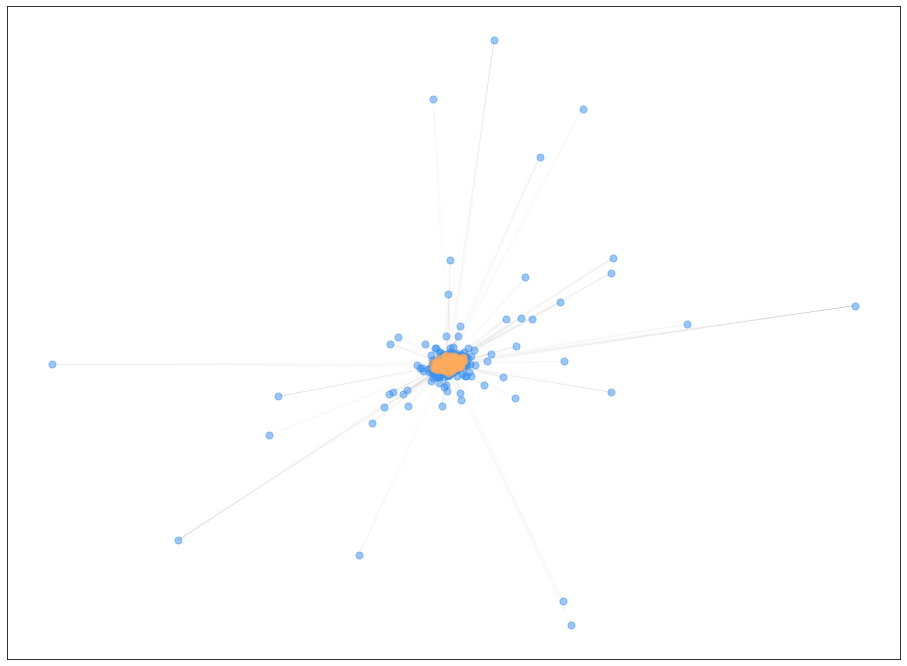

In [55]:
plt.figure(figsize=(16, 12))
nx.draw_networkx_edges(G, pos=feature_representations, edge_color=color_edge, alpha=alpha_edge)
for node, color in zip([app_nodes, lib_nodes], [color_apps,color_libs]):
    nx.draw_networkx_nodes(G, pos=feature_representations, nodelist=node, node_color=color, node_size=size_node, alpha=alpha_node)

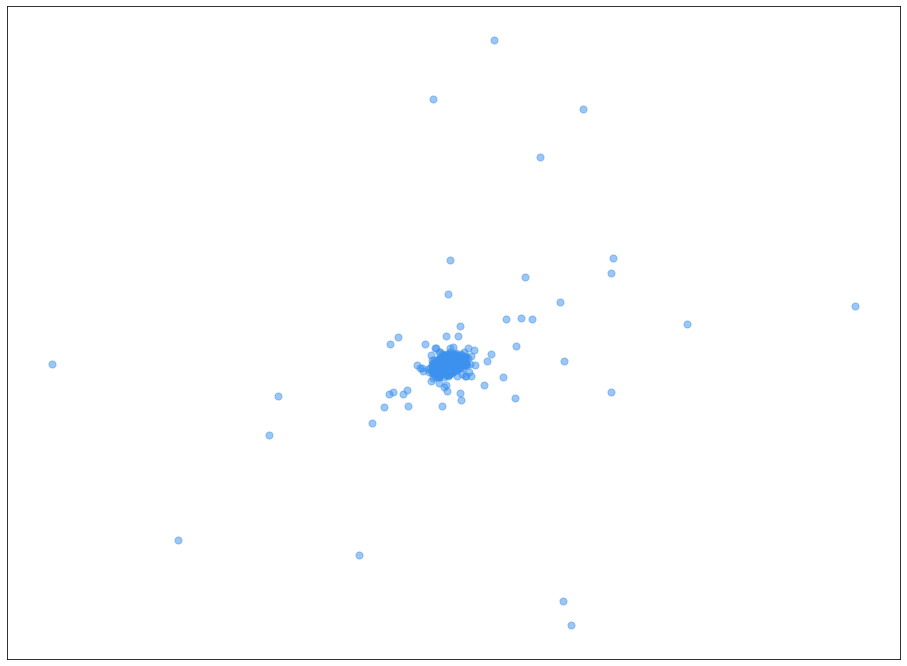

In [54]:
plt.figure(figsize=(16, 12))
nx.draw_networkx_nodes(G, pos=feature_representations, nodelist=app_nodes, node_color=color_apps, node_size=size_node, alpha=alpha_node)

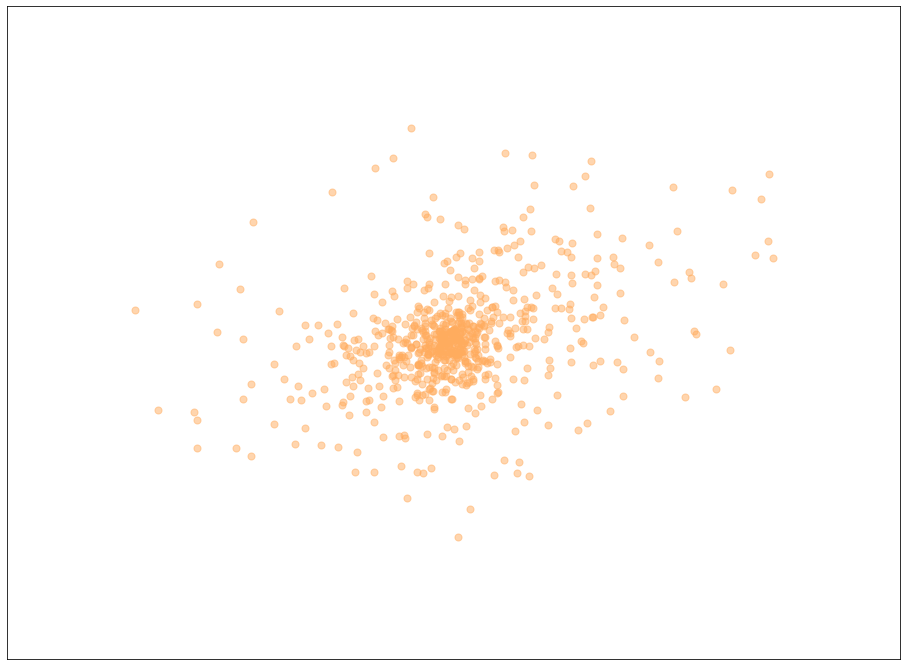

In [53]:
plt.figure(figsize=(16, 12))
nx.draw_networkx_nodes(G, pos=feature_representations, nodelist=lib_nodes, node_color=color_libs, node_size=size_node, alpha=alpha_node)